# Домашнее задание № 8

## Задание 1 (4 балла)

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
%pip install --upgrade keras
%pip install torch torchvision torchaudio datasets navec

In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [2]:
import keras
print(keras.__version__)

2.15.0


In [4]:
pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from datasets import load_dataset
# from tensorflow.keras.initializers import Constant
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
os.chdir("/content/drive/My Drive")

In [7]:
data = pd.read_csv('lenta_40k.csv')

In [8]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [11]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [14]:
MEAN_LEN = np.median([len(x) for x in X])

In [15]:
MAX_LEN = int(MEAN_LEN + 30)

In [16]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [17]:
X.shape

(44356, 200)

In [18]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [19]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

###1) модель с 1 GRU слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

rnn = keras.layers.GRU(64, return_sequences=False)(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(rnn)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 64)                  │          18,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 742,457 (2.83 MB)

 Trainable params: 742,457 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 204s 5s/step - loss: 2.8221 - rec@prec: 0.0000e+00 - val_loss: 2.3570 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - loss: 2.3298 - rec@prec: 1.0795e-04 - val_loss: 2.2768 - val_rec@prec: 0.0036
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 2.2124 - rec@prec: 9.8143e-04 - val_loss: 2.1249 - val_rec@prec: 0.0086
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 1.9996 - rec@prec: 0.0051 - val_loss: 1.9390 - val_rec@prec: 0.0113
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.7594 - rec@prec: 0.0574 - val_loss: 1.8734 - val_rec@prec: 0.0307
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 1.5969 - rec@prec: 0.1514 - val_loss: 1.7815 - val_rec@prec: 0.0532
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - loss: 1.4460 - rec@prec: 0.2457 - val_loss: 1.7395 - val_rec@prec: 0.0487
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 1.2826 - rec@prec: 0.3581 - val_loss: 1.656

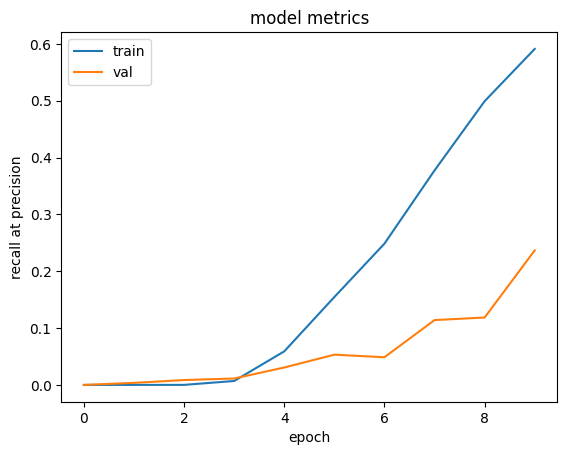

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###2) модель с 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = keras.layers.LSTM(64, return_sequences=False)(embeddings)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          24,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 748,345 (2.85 MB)

 Trainable params: 748,345 (2.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - loss: 2.7681 - rec@prec: 0.0000e+00 - val_loss: 2.3468 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - loss: 2.3213 - rec@prec: 0.0000e+00 - val_loss: 2.3061 - val_rec@prec: 0.0023
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 2.2363 - rec@prec: 0.0017 - val_loss: 2.0046 - val_rec@prec: 0.0487
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.8806 - rec@prec: 0.0691 - val_loss: 1.7778 - val_rec@prec: 0.0685
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - loss: 1.6570 - rec@prec: 0.1290 - val_loss: 1.6385 - val_rec@prec: 0.1736
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - loss: 1.4281 - rec@prec: 0.3193 - val_loss: 1.4474 - val_rec@prec: 0.2872
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - loss: 1.2594 - rec@prec: 0.4067 - val_loss: 1.4603 - val_rec@prec: 0.3206
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - loss: 1.1591 - rec@prec: 0.4724 - val_loss: 1.4004 - v

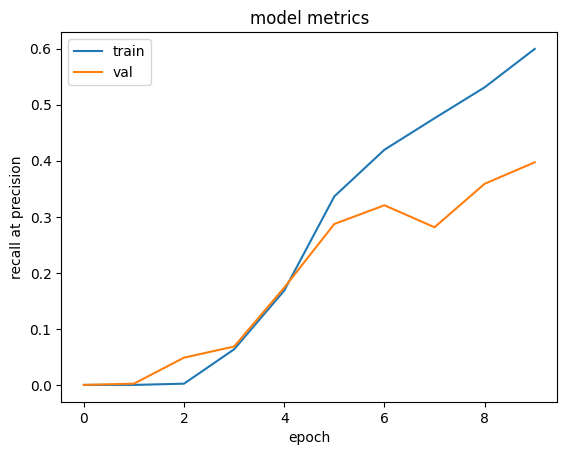

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=64)(inputs, )

gru_1 = keras.layers.GRU(64, return_sequences=True)(embeddings)
lstm_1 = keras.layers.LSTM(64, return_sequences=False)(gru_1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm_1)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_11 (Embedding)             │ (None, 200, 64)             │       1,541,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_39 (GRU)                         │ (None, 200, 64)             │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_29 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,601,171 (6.11 MB)

 Trainable params: 1,601,171 (6.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - loss: 2.6954 - rec@prec: 0.0000e+00 - val_loss: 2.3312 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 152s 4s/step - loss: 2.2333 - rec@prec: 7.6335e-05 - val_loss: 1.8647 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - loss: 1.8101 - rec@prec: 0.0363 - val_loss: 1.7591 - val_rec@prec: 0.0938
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 155s 4s/step - loss: 1.6275 - rec@prec: 0.0888 - val_loss: 1.6297 - val_rec@prec: 0.0947
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - loss: 1.5030 - rec@prec: 0.1097 - val_loss: 1.6076 - val_rec@prec: 0.1289
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 174s 4s/step - loss: 1.4042 - rec@prec: 0.1736 - val_loss: 1.5392 - val_rec@prec: 0.1569
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - loss: 1.3332 - rec@prec: 0.2091 - val_loss: 1.5094 - val_rec@prec: 0.1447
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - loss: 1.2163 - rec@prec: 0.2855 - val_loss

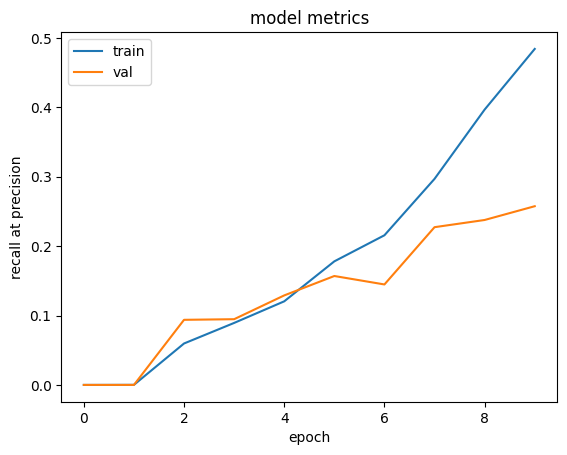

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True))(embeddings)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(bigru)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm2)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_14 (Embedding)             │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 200, 64)             │          12,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_34 (LSTM)                       │ (None, 200, 64)             │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_35 (LSTM)                       │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 802,361 (3.06 MB)

 Trainable params: 802,361 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 231s 5s/step - loss: 2.6673 - rec@prec: 0.0000e+00 - val_loss: 2.3343 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - loss: 2.3205 - rec@prec: 0.0000e+00 - val_loss: 2.2761 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 229s 5s/step - loss: 2.1474 - rec@prec: 0.0021 - val_loss: 1.9712 - val_rec@prec: 0.0388
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - loss: 1.9211 - rec@prec: 0.0313 - val_loss: 1.8035 - val_rec@prec: 0.0703
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - loss: 1.7310 - rec@prec: 0.0960 - val_loss: 1.7060 - val_rec@prec: 0.1258
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - loss: 1.6389 - rec@prec: 0.1338 - val_loss: 1.6626 - val_rec@prec: 0.1402
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 224s 5s/step - loss: 1.5469 - rec@prec: 0.1561 - val_loss: 1.6556 - val_rec@prec: 0.1307
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - loss: 1.4677 - rec@prec: 0.1710 - val_loss

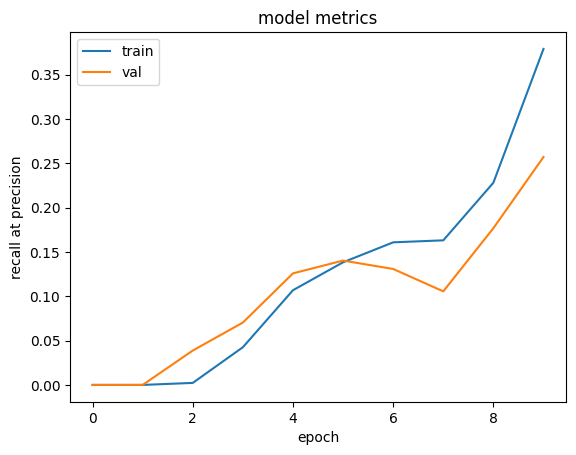

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###5) модель с 5 GRU слоями и 3 LSTM слоями

In [32]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru1 = keras.layers.GRU(128, return_sequences=True)(embeddings)
gru2 = keras.layers.GRU(128, return_sequences=True)(gru1)
lstm1 = keras.layers.LSTM(128, return_sequences=True)(gru2)
gru3 = keras.layers.GRU(128, return_sequences=True)(lstm1)
lstm2 = keras.layers.LSTM(128, return_sequences=True)(gru3)
gru4 = keras.layers.GRU(128, return_sequences=True)(lstm2)
lstm3 = keras.layers.LSTM(128, return_sequences=True)(gru4)
gru5 = keras.layers.GRU(128, return_sequences=False)(gru4)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(gru5)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [33]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_20 (GRU)                         │ (None, 200, 128)            │          61,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_21 (GRU)                         │ (None, 200, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_12 (LSTM)                       │ (None, 200, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_22 (GRU)                         │ (None, 200, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 200, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_23 (GRU)                         │ (None, 200, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_24 (GRU)                         │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,446,137 (5.52 MB)

 Trainable params: 1,446,137 (5.52 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 2.5471 - rec@prec: 0.0000e+00 - val_loss: 2.3099 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 2.2124 - rec@prec: 4.5959e-05 - val_loss: 1.8813 - val_rec@prec: 0.0045
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 1.7992 - rec@prec: 0.0065 - val_loss: 1.7282 - val_rec@prec: 0.0690
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - loss: 1.5510 - rec@prec: 0.1065 - val_loss: 1.4232 - val_rec@prec: 0.2570
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 1.1476 - rec@prec: 0.4292 - val_loss: 1.3225 - val_rec@prec: 0.3332
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.9166 - rec@prec: 0.6326 - val_loss: 1.3038 - val_rec@prec: 0.3959
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - loss: 0.8057 - rec@prec: 0.7168 - val_loss: 1.3549 - val_rec@prec: 0.4035
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - loss: 0.7274 - rec@prec: 0.7721 - val_loss: 1.3388 - v

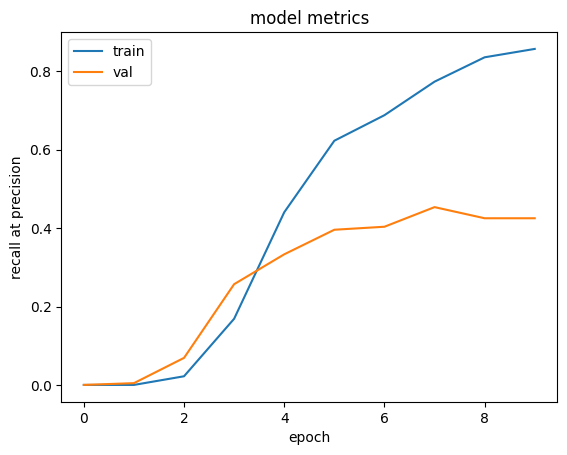

In [35]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались


In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru_forward = keras.layers.GRU(32, return_sequences=True)(embeddings)
gru_backward = keras.layers.GRU(32, return_sequences=True, go_backwards=True)(embeddings)
bigru = keras.layers.concatenate([gru_forward, gru_backward])

lstm_forward = keras.layers.LSTM(32, return_sequences=False)(bigru)
lstm_backward = keras.layers.LSTM(32, return_sequences=False, go_backwards=True)(bigru)
lstm = keras.layers.concatenate([lstm_forward, lstm_backward])

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26            │ (None, 200)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_26 (Embedding)  │ (None, 200, 30)        │        722,790 │ input_layer_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_68 (GRU)              │ (None, 200, 32)        │          6,144 │ embedding_26[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru_69 (GRU)              │ (None, 200, 32)        │          6,144 │ embedding_26[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 200, 64)        │              0 │ gru_68[0][0],          │
│ (Concatenate)             │                        │                │ gru_69[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_60 (LSTM)            │ (None, 32)             │         12,416 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_61 (LSTM)            │ (None, 32)             │         12,416 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 64)             │              0 │ lstm_60[0][0],         │
│ (Concatenate)             │                        │                │ lstm_61[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 19)             │          1,235 │ concatenate_10[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 761,145 (2.90 MB)

 Trainable params: 761,145 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - loss: 2.7772 - rec@prec: 0.0000e+00 - val_loss: 2.3425 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - loss: 2.3168 - rec@prec: 9.5198e-05 - val_loss: 2.2639 - val_rec@prec: 9.0171e-04
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - loss: 2.1604 - rec@prec: 0.0013 - val_loss: 1.9723 - val_rec@prec: 4.5086e-04
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 158s 4s/step - loss: 1.8489 - rec@prec: 0.0140 - val_loss: 1.6823 - val_rec@prec: 0.0555
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 157s 4s/step - loss: 1.6058 - rec@prec: 0.0787 - val_loss: 1.5240 - val_rec@prec: 0.1208
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - loss: 1.3701 - rec@prec: 0.2708 - val_loss: 1.3725 - val_rec@prec: 0.3413
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 156s 4s/step - loss: 1.1770 - rec@prec: 0.4529 - val_loss: 1.3326 - val_rec@prec: 0.3562
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 159s 4s/step - loss: 1.0676 - rec@prec: 0.5575 - val_

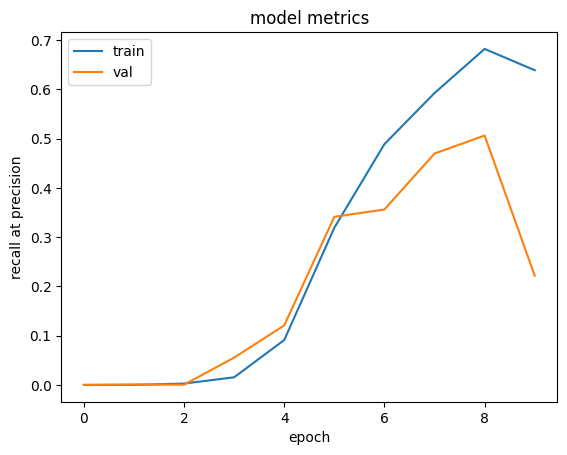

In [ ]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [36]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = keras.layers.LSTM(128, return_sequences=True)(embeddings)
gru1 = keras.layers.GRU(128, return_sequences=True)(lstm1)
bilstm = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True))(gru1)
bigru = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True))(bilstm)
gru2 = keras.layers.GRU(128, return_sequences=True)(bigru)
lstm2 = keras.layers.LSTM(128, return_sequences=False)(gru2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(lstm2)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [37]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 200, 30)             │         722,790 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 200, 128)            │          81,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_25 (GRU)                         │ (None, 200, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200, 128)            │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200, 128)            │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_27 (GRU)                         │ (None, 200, 128)            │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,309,689 (5.00 MB)

 Trainable params: 1,309,689 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=1000,
         epochs=10)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - loss: 2.5647 - rec@prec: 0.0000e+00 - val_loss: 2.3124 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 2.2980 - rec@prec: 0.0017 - val_loss: 1.9029 - val_rec@prec: 0.0523
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - loss: 1.7972 - rec@prec: 0.0689 - val_loss: 1.7100 - val_rec@prec: 0.1014
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 1.5654 - rec@prec: 0.1168 - val_loss: 1.6127 - val_rec@prec: 0.1145
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 1.4546 - rec@prec: 0.1567 - val_loss: 1.6263 - val_rec@prec: 0.1375
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 1.3518 - rec@prec: 0.2700 - val_loss: 1.4886 - val_rec@prec: 0.2227
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - loss: 1.2188 - rec@prec: 0.4164 - val_loss: 1.4334 - val_rec@prec: 0.2678
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - loss: 1.1102 - rec@prec: 0.5169 - val_loss: 1.4667

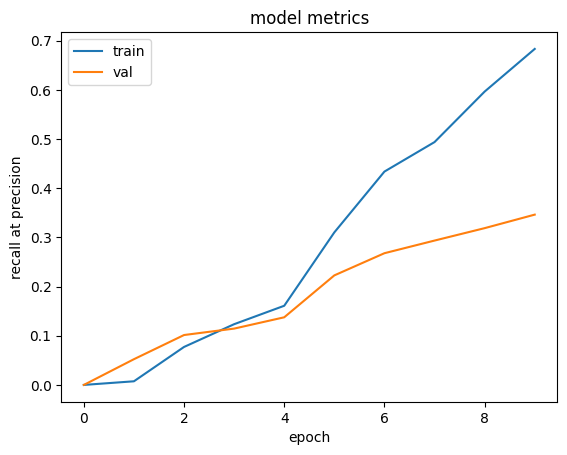

In [39]:
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

###*По графикам видно, что большинству моделей просто не хватило итераций для лучшего обучения, но это и так заняло слишком много времени, и даже не один день, так что вывод в текущих условиях следующий. Модель с чередующимися 5 GRU слоями и 3 LSTM слоями показала себя лучше других, получив recall 0.87 на трейне и 0,42 на валидации, хотя в перспективе, возможно стоит рассмотреть переход на другую, например 4-ю модель, так как её график показывает примерно одинаковую перспективу роста recall как на трейне, так и на валидации.*


##Задание 2 (6 баллов)

На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [6]:
dataset = load_dataset("tner/wikiann", 'ru')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for tner/wikiann contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tner/wikiann
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 10000
    })
})

In [8]:
# словарь
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [9]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199773 sha256=c6924df7113771b571880b554f1b7072bd55005b2b5e88e62cf6f5408759f5be
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [10]:
from huggingface_hub import hf_hub_download
import fasttext

model_fasttext = fasttext.load_model(hf_hub_download("facebook/fasttext-ru-vectors", "model.bin"))

model.bin:   0%|          | 0.00/7.26G [00:00<?, ?B/s]

In [11]:
# индексируем слова
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [12]:
id2word = {i:word for word, i in word2id.items()}

In [13]:
# переводим тексты в последовательности индексов
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [15]:
# переводим тексты в последовательности индексов
X_valid = []

for sent in dataset['validation']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_valid.append(ids)

In [16]:
# переводим тексты в последовательности индексов
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [17]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [18]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()}

In [19]:
y = keras.preprocessing.sequence.pad_sequences(dataset['train']['tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = keras.preprocessing.sequence.pad_sequences(dataset['test']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [20]:
y_valid = keras.preprocessing.sequence.pad_sequences(dataset['validation']['tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [21]:
embedding_dim = model_fasttext.get_dimension()
embedding_matrix = np.zeros((len(word2id), embedding_dim))

In [22]:
for word, idx in word2id.items():
    if word in model_fasttext:
        embedding_matrix[idx] = model_fasttext.get_word_vector(word)
    else:
        embedding_matrix[idx] = np.zeros(embedding_dim)
        pass

###1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев.

In [23]:
import tensorflow as tf

In [50]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=300, trainable=False,
                                       weights=[embedding_matrix])(inputs)

bilstm1 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(embeddings)
bilstm2 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bilstm1)
bilstm3 = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True))(bilstm2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(bilstm3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [51]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 54, 300)           10805100  
                                                                 
 bidirectional_11 (Bidirect  (None, 54, 256)           439296    
 ional)                                                          
                                                                 
 bidirectional_12 (Bidirect  (None, 54, 256)           394240    
 ional)                                                          
                                                                 
 bidirectional_13 (Bidirect  (None, 54, 256)           394240    
 ional)                                                          
                                                           

In [52]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 260s 2s/step - loss: 0.1932 - accuracy: 0.9393 - val_loss: 0.1355 - val_accuracy: 0.9557
Epoch 2/5
157/157 [==============================] - 254s 2s/step - loss: 0.1080 - accuracy: 0.9642 - val_loss: 0.0921 - val_accuracy: 0.9686
Epoch 3/5
157/157 [==============================] - 241s 2s/step - loss: 0.0703 - accuracy: 0.9767 - val_loss: 0.0711 - val_accuracy: 0.9768
Epoch 4/5
157/157 [==============================] - 242s 2s/step - loss: 0.0515 - accuracy: 0.9831 - val_loss: 0.0665 - val_accuracy: 0.9775
Epoch 5/5
157/157 [==============================] - 242s 2s/step - loss: 0.0457 - accuracy: 0.9850 - val_loss: 0.0690 - val_accuracy: 0.9781


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


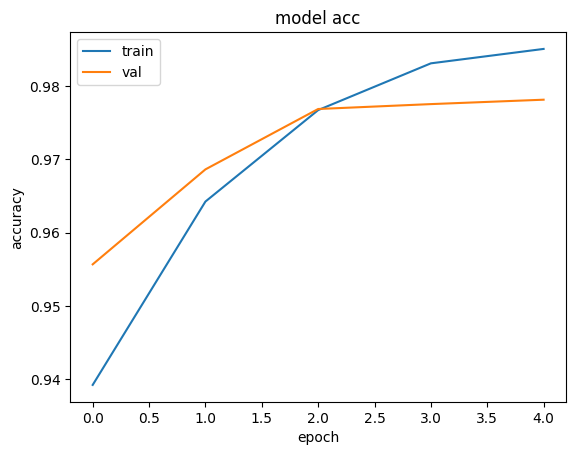

In [53]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
from sklearn.metrics import classification_report

In [55]:
pred = model.predict(X_test).argmax(2)

313/313 [==============================] - 65s 201ms/step


In [57]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.82      0.57      0.67      4560
       B-PER       0.52      0.61      0.56      4074
       I-PER       0.96      0.62      0.75      3542
       B-ORG       0.92      0.46      0.61      3060
       I-ORG       0.63      0.82      0.72      8008
       B-LOC       0.97      0.76      0.85      7544
       I-LOC       0.89      0.95      0.92     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.72      0.76    540000
weighted avg       0.98      0.98      0.98    540000



In [33]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(keras.preprocessing.sequence.pad_sequences([ids],
                                                                       maxlen=max_len,
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))

    return list(zip(tokens, labels))

In [62]:
label_seq('Маша и Катя идут по мосту, который построили при Александре Втором, в Санкт-Петербурге, а кто построил, этого Компании не известно', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 135ms/step


[('Маша', 'B-PER'),
 ('и', 'I-LOC'),
 ('Катя', 'I-LOC'),
 ('идут', 'I-LOC'),
 ('по', 'I-LOC'),
 ('мосту', 'I-LOC'),
 (',', 'I-LOC'),
 ('который', 'I-LOC'),
 ('построили', 'I-LOC'),
 ('при', 'I-LOC'),
 ('Александре', 'I-LOC'),
 ('Втором', 'I-LOC'),
 (',', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Санкт', 'I-LOC'),
 ('-', 'I-LOC'),
 ('Петербурге', 'I-LOC'),
 (',', 'I-LOC'),
 ('а', 'I-LOC'),
 ('кто', 'I-LOC'),
 ('построил', 'I-LOC'),
 (',', 'I-LOC'),
 ('этого', 'I-LOC'),
 ('Компании', 'I-LOC'),
 ('не', 'I-LOC'),
 ('известно', 'I-LOC')]

In [64]:
label_seq('Петр Семенович был очень рад, когда узнал, что его любимую Ладу эвакуировал Иванов Иван, сотрудник Госавтоинспекции.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 59ms/step


[('Петр', 'I-PER'),
 ('Семенович', 'I-LOC'),
 ('был', 'I-LOC'),
 ('очень', 'I-LOC'),
 ('рад', 'I-LOC'),
 (',', 'I-LOC'),
 ('когда', 'I-LOC'),
 ('узнал', 'I-LOC'),
 (',', 'I-LOC'),
 ('что', 'I-LOC'),
 ('его', 'I-LOC'),
 ('любимую', 'I-LOC'),
 ('Ладу', 'I-LOC'),
 ('эвакуировал', 'I-LOC'),
 ('Иванов', 'I-ORG'),
 ('Иван', 'I-ORG'),
 (',', 'I-LOC'),
 ('сотрудник', 'I-LOC'),
 ('Госавтоинспекции', 'I-LOC'),
 ('.', 'I-LOC')]

###2) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев.

In [24]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=300, trainable=False,
                                       weights=[embedding_matrix])(inputs)

bigru1 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru2 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(bigru1)
bigru3 = keras.layers.Bidirectional(keras.layers.GRU(128, return_sequences=True))(bigru2)

outputs = keras.layers.Dense(len(label2id), activation='softmax')(bigru3)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])


In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 54)]              0         
                                                                 
 embedding (Embedding)       (None, 54, 300)           10805100  
                                                                 
 bidirectional (Bidirection  (None, 54, 256)           330240    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 54, 256)           296448    
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 54, 256)           296448    
 onal)                                                           
                                                             

In [26]:
model.fit(X, y,
          validation_data=(X_test, y_test),
          batch_size=128,
         epochs=5)

Epoch 1/5
157/157 [==============================] - 18s 46ms/step - loss: 0.1656 - accuracy: 0.9457 - val_loss: 0.0968 - val_accuracy: 0.9680
Epoch 2/5
157/157 [==============================] - 5s 31ms/step - loss: 0.0671 - accuracy: 0.9779 - val_loss: 0.0847 - val_accuracy: 0.9737
Epoch 3/5
157/157 [==============================] - 5s 32ms/step - loss: 0.0495 - accuracy: 0.9836 - val_loss: 0.0797 - val_accuracy: 0.9759
Epoch 4/5
157/157 [==============================] - 5s 32ms/step - loss: 0.0434 - accuracy: 0.9857 - val_loss: 0.0839 - val_accuracy: 0.9760
Epoch 5/5
157/157 [==============================] - 5s 34ms/step - loss: 0.0394 - accuracy: 0.9871 - val_loss: 0.0860 - val_accuracy: 0.9760


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


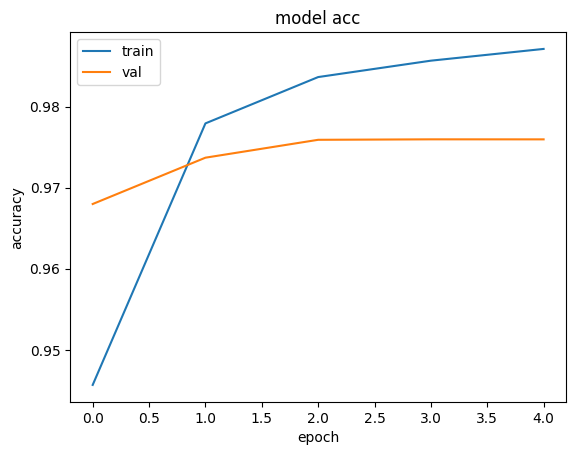

In [27]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
from sklearn.metrics import classification_report

In [29]:
pred = model.predict(X_test).argmax(2)

313/313 [==============================] - 6s 10ms/step


In [31]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.83      0.48      0.61      4560
       B-PER       0.57      0.56      0.56      4074
       I-PER       0.91      0.52      0.66      3542
       B-ORG       0.92      0.49      0.64      3060
       I-ORG       0.78      0.69      0.73      8008
       B-LOC       0.95      0.72      0.82      7544
       I-LOC       0.83      0.98      0.90     40480
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.85      0.68      0.74    540000
weighted avg       0.98      0.98      0.97    540000



In [34]:
label_seq('Маша и Катя идут по мосту, который построили при Александре Втором, в Санкт-Петербурге, а кто построил, этого Компании не известно', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 58ms/step


[('Маша', 'B-PER'),
 ('и', 'I-LOC'),
 ('Катя', 'I-LOC'),
 ('идут', 'I-LOC'),
 ('по', 'I-LOC'),
 ('мосту', 'I-LOC'),
 (',', 'I-LOC'),
 ('который', 'I-LOC'),
 ('построили', 'I-LOC'),
 ('при', 'I-LOC'),
 ('Александре', 'I-LOC'),
 ('Втором', 'I-LOC'),
 (',', 'I-LOC'),
 ('в', 'I-LOC'),
 ('Санкт', 'I-LOC'),
 ('-', 'I-LOC'),
 ('Петербурге', 'I-LOC'),
 (',', 'I-LOC'),
 ('а', 'I-LOC'),
 ('кто', 'I-LOC'),
 ('построил', 'I-LOC'),
 (',', 'I-LOC'),
 ('этого', 'I-LOC'),
 ('Компании', 'I-LOC'),
 ('не', 'I-LOC'),
 ('известно', 'I-LOC')]

In [35]:
label_seq('Петр Семенович был очень рад, когда узнал, что его любимую Ладу эвакуировал Иванов Иван, сотрудник Госавтоинспекции.', word2id, id2labels, MAX_LEN, model)

1/1 [==============================] - 0s 47ms/step


[('Петр', 'I-PER'),
 ('Семенович', 'I-LOC'),
 ('был', 'I-LOC'),
 ('очень', 'I-LOC'),
 ('рад', 'I-LOC'),
 (',', 'I-LOC'),
 ('когда', 'I-LOC'),
 ('узнал', 'I-LOC'),
 (',', 'I-LOC'),
 ('что', 'I-LOC'),
 ('его', 'I-LOC'),
 ('любимую', 'I-LOC'),
 ('Ладу', 'I-LOC'),
 ('эвакуировал', 'I-LOC'),
 ('Иванов', 'I-PER'),
 ('Иван', 'B-LOC'),
 (',', 'I-LOC'),
 ('сотрудник', 'I-LOC'),
 ('Госавтоинспекции', 'I-LOC'),
 ('.', 'I-LOC')]

###Выводы

Если смотреть исключительно по метрикам, то можно сделать вывод, что модели работают на очень схожем уровне и первая модель показывает даже немного лучшие результаты на classification report. Однако, предложенные примеры показывают, что во-первых модели в целом не очень способны выдавать стабильный результат, а во-вторых, вторая модель показала себя немного лучше, потому что не назвала Иванова Ивана организацией, и даже пределила фамилию относящейся к person классу. Тем не менее, в остальном обе модели присволи остальным словам класс I-LOC, согласившись только на том, что Маша - это person.